# One-sided Unpaired Medical Image Translation with
# Normalized Edge Consistency
A pix2pix-like model with a multi stage discriminator using only a GAN loss and a NGF loss between predicted and source to preserve structures. 

This is the 'official' implementation of paper  https://ieeexplore.ieee.org/abstract/document/10635150
- Author: Vincent Jaouen - IMT Atlantique, Inserm LaTIM - Brest, France  - vincent.jaouen@imt-atlantique.fr

In [ ]:
import nibabel as nib
import os, glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset, PatchDataset
from monai.inferers import SliceInferer
from monai.utils import set_determinism, first
from monai.transforms import(
    Compose,
    Lambdad,
    LoadImaged,
    EnsureChannelFirstd,
    SqueezeDimd, 
    RandSpatialCropSamplesd, 
    ScaleIntensityRangePercentilesd, 
    ScaleIntensityRanged, 
    Resized,
    CropForegroundd, 
    CenterSpatialCropd, 
    RandZoomd
)
# print_config()
from datetime import date
today = str(date.today()).replace('-','').replace(' ', '')
gpu_device = torch.device(f'cuda:{0}')

In [ ]:
class Options():
    def __init__(self):
        # model parameters
        self.in_channels = 1  
        self.out_channels = 1  
        self.num_filters_d = 128  # number of filters in the discriminator
        self.num_layers_d = 4  # number of layers in the discriminator (i.e. the receptive field)
        self.num_d = 2 # number of discriminators (à la pix2pix HD)
        self.num_res_units_G = 18 # 

        # training parameters
        self.N_train = 500 # number of patient IDs for training (you need at least 2*N total as we perform unpaired training)
        self.num_epochs=400  # 300 is enough
        self.learning_rate = 2e-4  # typical value for CycleGAN
        self.lambda_identity = 0  # identity loss
        self.lambda_gan = 1 # GAN loss weight
        self.lambda_NGF=3 # 
        self.alpha_NGF=.1 # best .15
        self.lambda_l1=0 #  # best 100 for pix2pix, no reconstruction loss for unpaired training

        # I/0
        self.where_is_BraTS='/home/jet/DATA/PUBLIC/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData' # original BraTS23 data folder
        self.where_is_BraTS_2d = self.where_is_BraTS+'_2d' # where 2d images will be stored for training
        self.results_dir = '/home/jet/DATA/RESULTS'
        self.EXPERIMENT_PREFIX='EXP001-n%d-l%d-f%d' % (self.num_d, self.num_layers_d, self.num_filters_d) + '_GAN%d_L%.2f_NGF%.2f_a%.2f' % (self.lambda_gan, self.lambda_l1, self.lambda_NGF, self.alpha_NGF)

opt=Options()

In [ ]:
opt.EXPERIMENT_PREFIX

# 3D to 2D pre-processing 

#### Custom Rand spatial transform to reject peripheral axial slices that show too many zeros

In [ ]:
class RandSpatialCropSamplesdWithMinNonZero(RandSpatialCropSamplesd):
    def __init__(self, min_nonzero: int=10000, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_nonzero = min_nonzero

    def __call__(self, data, lazy=False):
        # Use the base class to generate initial samples.
        samples = super().__call__(data)
        valid_samples = []

        # Check each sample for the non-zero pixel condition.
        for sample in samples:
            for key in self.keys:
                if np.count_nonzero(sample[key]) >= self.min_nonzero:
                    valid_samples.append(sample)
                    break  # Assuming at least one key meets the condition is enough.

        # Ensure we have at least one valid sample to avoid empty returns.
        if not valid_samples:
            raise ValueError("No valid samples found. Consider adjusting the min_nonzero parameter.")
        return valid_samples

#### Conversion 3D to 2D

Get original BraTS images, define splits, slice them and write into a 2D folder

In [ ]:
from natsort import natsorted
import glob
PIDs_ALL = [i.split('/')[-1] for i in glob.glob(os.path.join(opt.where_is_BraTS,'BraTS*'))]
N=500 # number of training IDs
np.random.seed(29100) # only work with postcodes of beautiful towns
np.random.shuffle(PIDs_ALL)

1) Train

In [ ]:
PIDs_train_A = PIDs_ALL[:N]
PIDs_train_B = PIDs_ALL[N:2*N]

fnames_train_A_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t1n.nii.gz') for PID in PIDs_train_A]
fnames_train_B_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t2w.nii.gz') for PID in PIDs_train_B]
train_dic_3d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_train_A_3d, 
    fnames_train_B_3d
)] 

2. Validation set

In [ ]:
PIDs_val = PIDs_ALL[2*N:2*N+10]

fnames_val_A_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t1n.nii.gz') for PID in PIDs_val]
fnames_val_B_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t2w.nii.gz') for PID in PIDs_val]
val_dic_3d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_val_A_3d, 
    fnames_val_B_3d
)] 

3. Test

In [ ]:
PIDs_test= PIDs_ALL[2*N+10:2*N+20]

fnames_test_A_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t1n.nii.gz') for PID in PIDs_test]
fnames_test_B_3d = [os.path.join(opt.where_is_BraTS, PID, PID+'-t2w.nii.gz') for PID in PIDs_test]
test_dic_3d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_test_A_3d, 
    fnames_test_B_3d
)] 

Apply transforms : Perform the 3D to 2D slicing and transforms, then write to disk

In [ ]:
from monai.transforms import Compose, Transform, MapTransform
from monai.transforms import ScaleIntensityRangePercentiles
NUM_SAMPLES_MAX=25
train_transforms = Compose(
    [
        LoadImaged(keys=["SRC", "TGT"], image_only=False),
        EnsureChannelFirstd(keys=["SRC", "TGT"]),
        ScaleIntensityRangePercentilesd(keys=["TGT", "SRC"], lower=1, upper=99.9, b_min=0,b_max=1, clip=True),
        RandSpatialCropSamplesdWithMinNonZero(keys=["SRC", "TGT"], roi_size=(-1,-1,1), random_size=False, num_samples=NUM_SAMPLES_MAX),
        ScaleIntensityRanged(keys=["TGT", "SRC"], a_min=0, a_max = 1, b_min=-1, b_max=1),
        Resized(keys=["SRC", "TGT"], spatial_size=[256,256,-1], mode="trilinear"), # make it 256**2 to make sure we downsample correctly
        SqueezeDimd(keys=["SRC", "TGT"], dim=0),
    ]
)

valtest_transforms = Compose(
    [
        LoadImaged(keys=["SRC", "TGT"], image_only=False),
        EnsureChannelFirstd(keys=["SRC", "TGT"]),
        ScaleIntensityRangePercentilesd(keys=["TGT", "SRC"], lower=1, upper=99.9, b_min=0,b_max=1, clip=True),
        CenterSpatialCropd(keys=["SRC", "TGT"], roi_size=(-1,-1,1)),
        ScaleIntensityRanged(keys=["TGT", "SRC"], a_min=0, a_max = 1, b_min=-1, b_max=1),
        Resized(keys=["SRC", "TGT"], spatial_size=[256,256,-1], mode="trilinear"), # make it 256**2 to make sure we downsample correctly
        SqueezeDimd(keys=["SRC", "TGT"], dim=0),
    ]
)

1) Train

In [ ]:
# This is a flag to decide to slice the 3D BraTS original data for training
# This is to be done only once.
PROCESS_DATA=False

In [ ]:
if PROCESS_DATA:
    outdir=os.path.join(opt.where_is_BraTS_2d,'t1')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(train_dic_3d)):       
        transformed_image = train_transforms(train_dic_3d[i])
        fname_ref = transformed_image[0]['SRC_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        for j in range(len(transformed_image)):
            fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sample%.3d.nii.gz' % j))
            nib.save(nib.Nifti1Image(transformed_image[j]['SRC'][:,:,0].numpy(), None, nii_ref.header), fname_out)
    
    outdir=os.path.join(opt.where_is_BraTS_2d,'t2')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(train_dic_3d)):
        transformed_image = train_transforms(train_dic_3d[i])
        fname_ref = transformed_image[0]['TGT_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        for j in range(len(transformed_image)):
            fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sample%.3d.nii.gz' % j))
            nib.save(nib.Nifti1Image(transformed_image[j]['TGT'][:,:,0].numpy(), None, nii_ref.header), fname_out)

2) Val

In [ ]:
if PROCESS_DATA:
    outdir=os.path.join(opt.where_is_BraTS_2d,'t1_val')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(val_dic_3d)):
        transformed_image = valtest_transforms(val_dic_3d[i])
        fname_ref = transformed_image['SRC_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sCenter.nii.gz'))
        nib.save(nib.Nifti1Image(transformed_image['SRC'][:,:,0].numpy(), None, nii_ref.header), fname_out)
    
    outdir=os.path.join(opt.where_is_BraTS_2d,'t2_val')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(val_dic_3d)):
        transformed_image = valtest_transforms(val_dic_3d[i])
        fname_ref = transformed_image['TGT_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        
        fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sCenter.nii.gz'))
        nib.save(nib.Nifti1Image(transformed_image['TGT'][:,:,0].numpy(), None, nii_ref.header), fname_out)

3) Test

In [ ]:
if PROCESS_DATA:
    outdir=os.path.join(opt.where_is_BraTS_2d,'t1_test')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(test_dic_3d)):
        transformed_image = valtest_transforms(test_dic_3d[i])
        fname_ref = transformed_image['SRC_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sCenter.nii.gz'))
        nib.save(nib.Nifti1Image(transformed_image['SRC'][:,:,0].numpy(), None, nii_ref.header), fname_out)
    
    outdir=os.path.join(opt.where_is_BraTS_2d,'t2_test')
    os.makedirs(outdir, exist_ok=True)
    from monai.data import NibabelWriter
    for i in range(len(test_dic_3d)):
        transformed_image = valtest_transforms(test_dic_3d[i])
        fname_ref = transformed_image['TGT_meta_dict']['filename_or_obj']
        print(fname_ref.split('/')[-1])
        nii_ref = nib.load(fname_ref)
        
        fname_out = os.path.join(outdir, fname_ref.split('/')[-1].split('.')[0]+('_sCenter.nii.gz'))
        nib.save(nib.Nifti1Image(transformed_image['TGT'][:,:,0].numpy(), None, nii_ref.header), fname_out)

# 2D processing 

In [ ]:
transforms_2d = Compose(
    [
        LoadImaged(keys=["SRC", "TGT"], image_only=False),
        EnsureChannelFirstd(keys=["SRC", "TGT"]),
    ]
)
BATCH_SIZE=1
NUM_WORKERS=4

- Train

In [ ]:
fnames_train_A_2d = glob.glob(os.path.join(opt.where_is_BraTS_2d, 't1', '*.nii.gz'))
fnames_train_B_2d = glob.glob(os.path.join(opt.where_is_BraTS_2d, 't2', '*.nii.gz'))
train_dic_2d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_train_A_2d, 
    fnames_train_B_2d
)] 

train_ds = CacheDataset(train_dic_2d, transforms_2d)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

- Val

In [ ]:
fnames_val_A_2d = sorted(glob.glob(os.path.join(opt.where_is_BraTS_2d, 't1_val', '*.nii.gz')))
fnames_val_B_2d = sorted(glob.glob(os.path.join(opt.where_is_BraTS_2d, 't2_val', '*.nii.gz')))
val_dic_2d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_val_A_2d, 
    fnames_val_B_2d
)] 

val_ds = CacheDataset(val_dic_2d, transforms_2d)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

- Test

In [ ]:
fnames_test_A_2d = sorted(glob.glob(os.path.join(opt.where_is_BraTS_2d, 't1_test', '*.nii.gz')))
fnames_test_B_2d = sorted(glob.glob(os.path.join(opt.where_is_BraTS_2d, 't2_test', '*.nii.gz')))
test_dic_2d = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_test_A_2d, 
    fnames_test_B_2d
)] 

test_ds = CacheDataset(test_dic_2d, transforms_2d)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
check_data = first(val_loader)
print("first patch's shape: ", check_data["SRC"].shape)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(check_data["TGT"][0,0,:,:].detach().cpu().numpy().squeeze(), vmin=-1, vmax=1, cmap="gray")
plt.title('Target')
plt.subplot(1,4,2)
plt.imshow(check_data["SRC"][0,0,:,:].detach().cpu().numpy().squeeze(), vmin=-1, vmax=1, cmap="gray")
plt.title('Source')

In [ ]:
from vjnetworks import Pix2Pix

In [ ]:
import torch.optim
import torch.nn.functional as F
import monai.networks.nets as nets

pix2pix_model = Pix2Pix(
    in_channels=opt.in_channels,
    out_channels=opt.out_channels,
    num_d=opt.num_d,
    num_layers_d=opt.num_layers_d,
    num_filters_d=opt.num_filters_d,
    num_res_units_G=opt.num_res_units_G,
)
learning_rate = 1e-4  # Adjust the learning rate as needed
optimizer = torch.optim.Adam(pix2pix_model.parameters(), lr=learning_rate)

In [ ]:
## load from existing weights
# weights_path = '/home/jet/pCloudDrive_LOCAL/CODE/PYTHON/SR/BraTS2024_nocrop-n2-l4-f128_GAN1_L0.00_NGF1.00_a0.10/BraTS2024_nocrop-n2-l4-f128_GAN1_L0.00_NGF1.00_a0.10_e0043.h5'
# checkpoint = torch.load(weights_path)
# pix2pix_model.load_state_dict(checkpoint['model'], strict=False)
# pix2pix_model.to(gpu_device).eval()

In [ ]:
# where to save results
weights_dir = os.path.join(opt.results_dir, opt.EXPERIMENT_PREFIX)
os.makedirs(weights_dir, exist_ok=True)

In [ ]:
import imageio.v2 as imageio
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.exposure import match_histograms


In [ ]:
# print(EXPERIMENT_PREFIX)
print(weights_dir)
VAL_ID=1 # chose the validation image to display and show metrics from
for i, real_val in enumerate(val_loader):
    if i == VAL_ID:
        real_B_val = real_val["TGT"].to(gpu_device)
        # Simplify the transformation and type conversion in one step
        real_B_val_0255 = ((real_B_val[0, 0].cpu().numpy() + 1) * 127.5).astype(np.uint8)
        fname_out = os.path.join(weights_dir, 'real_B.png')
        imageio.imwrite(fname_out, real_B_val_0255)
        break  # Exit the loop after processing the needed item

Epoch [27/400]: 100%|██| 6781/6781 [13:11<00:00,  8.56it/s, losses=[ 0.42 2.88]]


21.99 dB


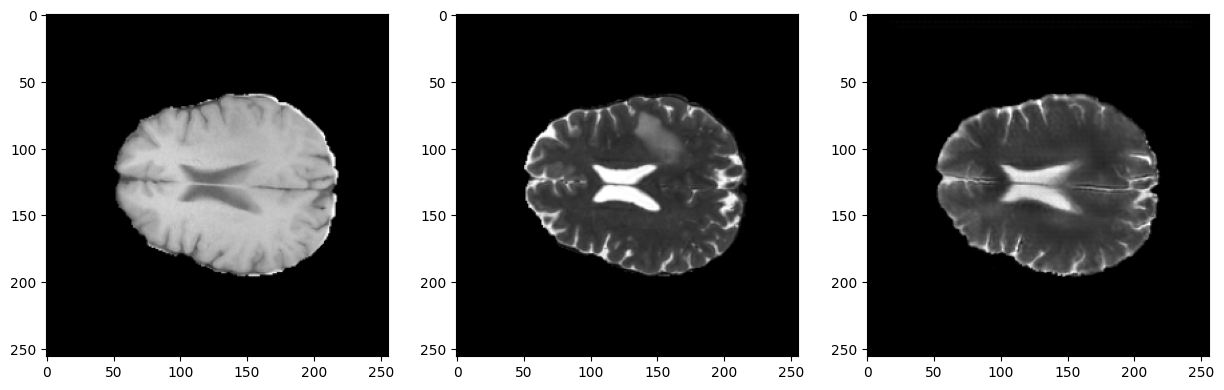

25.37 dB


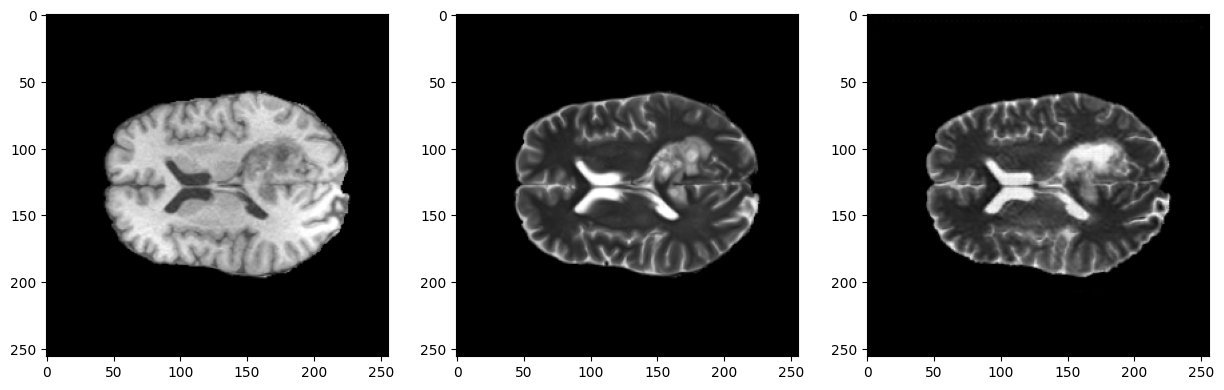

26.00 dB


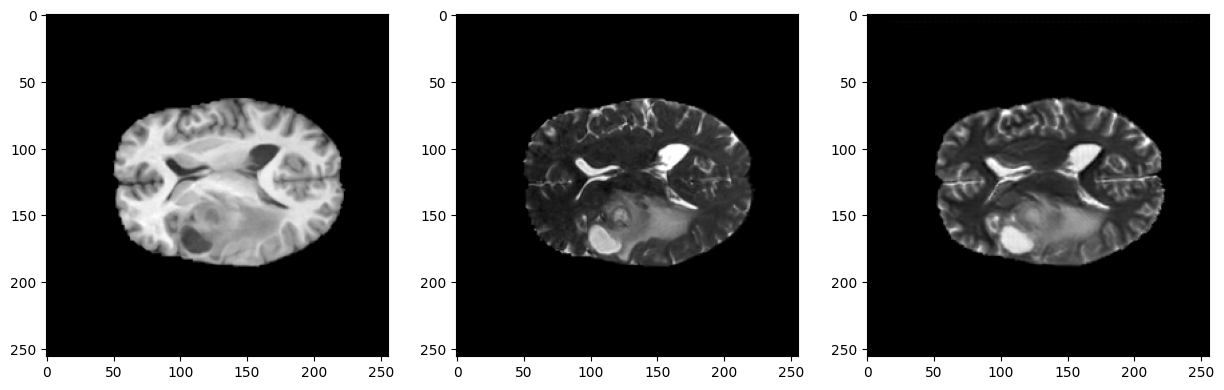

22.92 dB


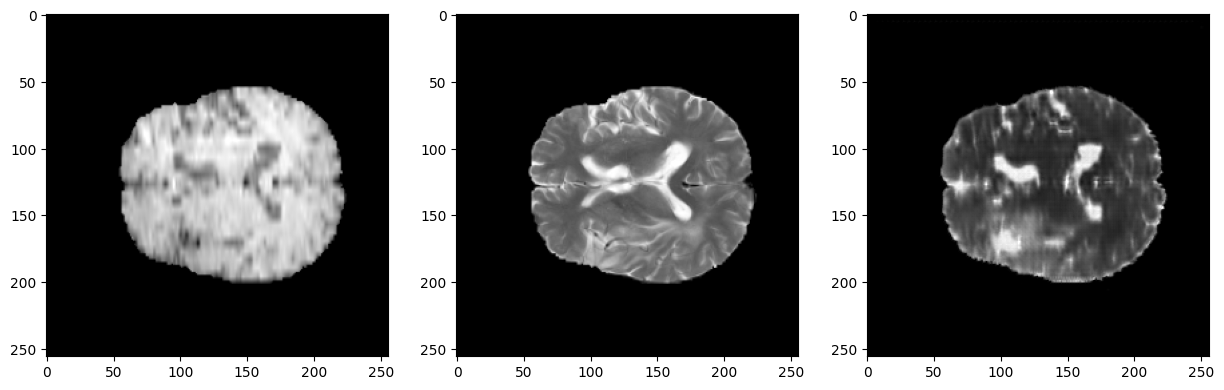

24.18 dB


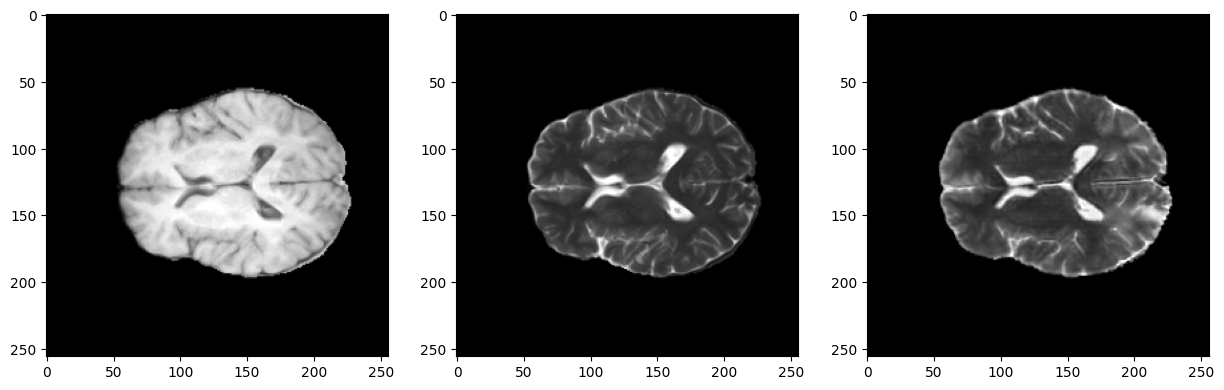

21.89 dB


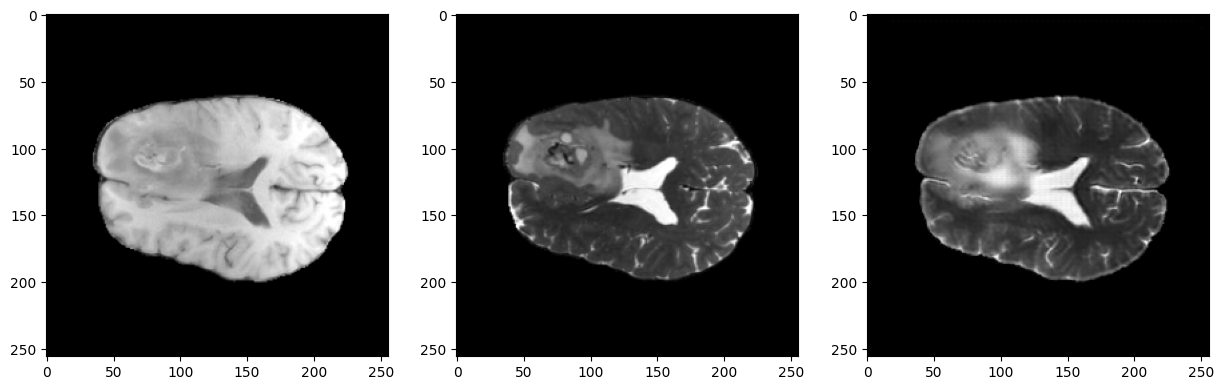

25.24 dB


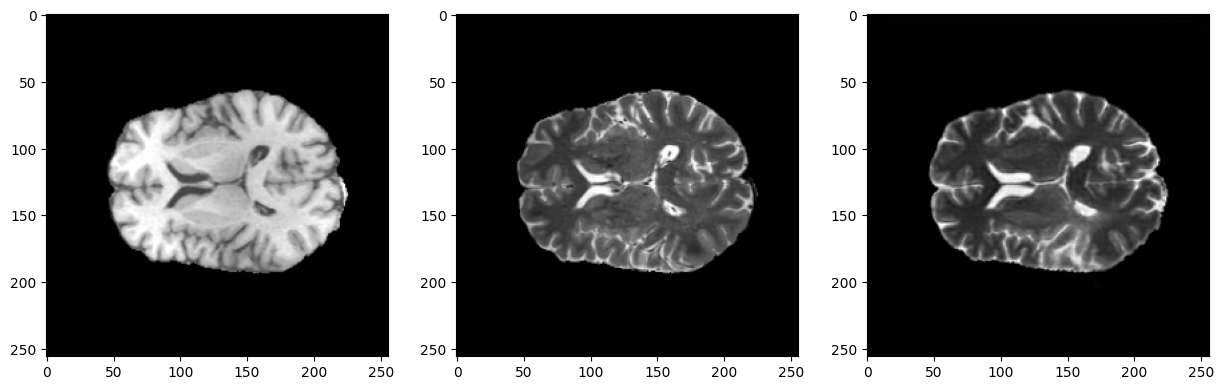

23.95 dB


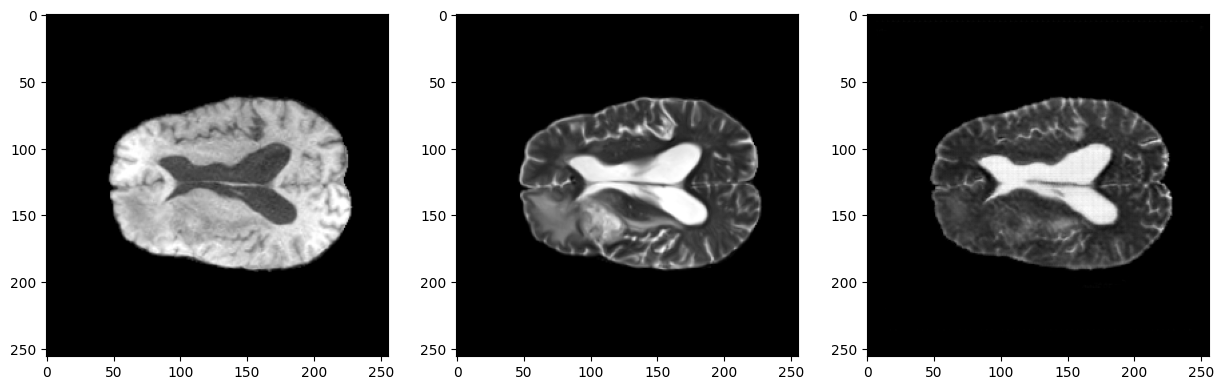

22.53 dB


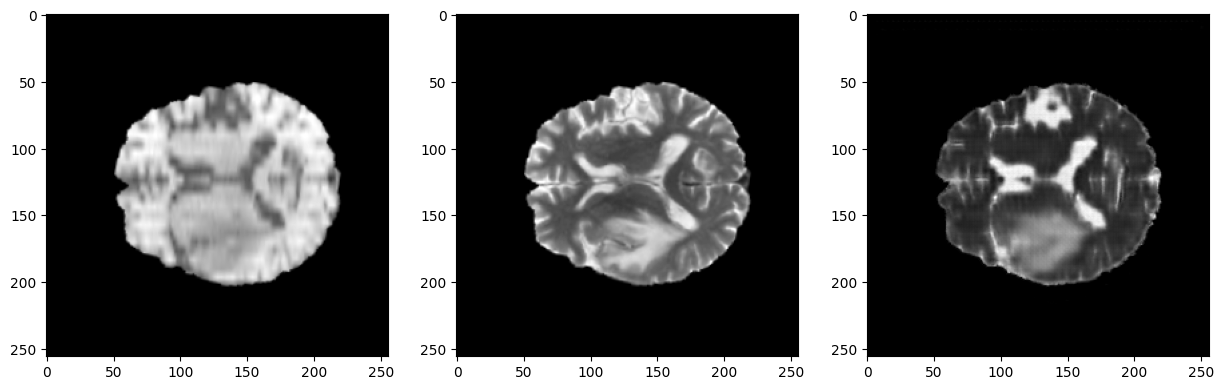

25.96 dB


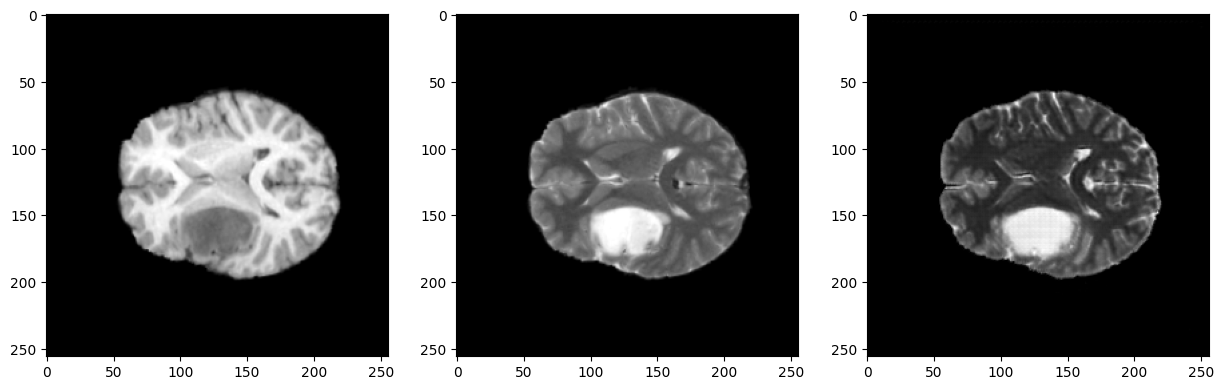

average PSNR = 24.005


Epoch [28/400]:   3%|   | 215/6781 [00:26<13:28,  8.12it/s, losses=[ 0.41 2.94]]


KeyboardInterrupt: 

In [30]:
PSNRs=[]
from tqdm import tqdm
for epoch in np.arange(1,opt.num_epochs+1):
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch}/{opt.num_epochs}]")

    # this is autoencoding for the first epoch, this usually helps the network
    if epoch < 2:
        real_B_is = "SRC"
        opt.lambda_l1=100.
    else:
    # this is normal unpaired image translation behaviour 
        real_B_is = "TGT"
        opt.lambda_l1=0.
    
    for batch_idx, real in enumerate(loop):
        # Transfer data to the device (CPU or GPU)
        real_A = real["SRC"].to(gpu_device)
        real_B = real[real_B_is].to(gpu_device)
        

        # Forward pass
        fake_B, identity_B, pred_fake_B = pix2pix_model(real_A, real_B, is_training=True)
        generator_loss = 0.0
        if opt.lambda_l1:
            l1_loss = pix2pix_model.compute_l1_loss(fake_B, real_B)
            generator_loss += opt.lambda_l1*l1_loss
        if opt.lambda_NGF:
            NGF_loss = pix2pix_model.compute_NGF_loss(fake_B, real_A, opt.alpha_NGF)
            generator_loss += opt.lambda_NGF*NGF_loss
        if opt.lambda_gan:
            adv_loss = pix2pix_model.compute_adv_loss(pred_fake_B)
            generator_loss += opt.lambda_gan*adv_loss            
        if opt.lambda_identity:
            identity_loss = pix2pix_model.compute_identity_loss(real_B)
            generator_loss += opt.lambda_identity*identity_loss            
       
        # discriminator
        discriminator_loss = pix2pix_model.compute_discriminator_loss(real_B, fake_B)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        generator_loss.backward()
        discriminator_loss.backward()
        optimizer.step()     
        
        if opt.lambda_NGF:
            loop.set_postfix(losses=f"[ {(adv_loss * opt.lambda_gan).item():.2f} {(NGF_loss * opt.lambda_NGF).item():.2f}] ")    

    # VALIDATION
    current_psnrs=[]
    for i, real_val in enumerate(val_loader):
        real_A_val = real_val["SRC"].to(gpu_device)
        real_B_val = real_val["TGT"].to(gpu_device)
        fake_B_val= pix2pix_model(real_A_val, real_B_val, is_training=True)[0]
        fake_B_val_0255 = np.uint8(np.clip(255*(fake_B_val[0,0,:,:,].cpu().detach().numpy().squeeze()+1)/2, 0,255))
        real_B_val_0255 = np.uint8(np.clip(255*(real_B_val[0,0,:,:,].cpu().detach().numpy().squeeze()+1)/2, 0,255))
        real_A_val_0255 = np.uint8(np.clip(255*(real_A_val[0,0,:,:,].cpu().detach().numpy().squeeze()+1)/2, 0,255))
        current_psnr = psnr(match_histograms(fake_B_val_0255, real_B_val_0255), np.float32(real_B_val_0255), data_range=(256))
        current_psnrs.append(current_psnr)
        
        print('%.2f dB' % current_psnr)
        
        if True: # i==VAL_ID:
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.imshow(real_A_val[0,0,:,:,].cpu().detach().numpy().squeeze(), vmin=-1, vmax=1, cmap='gray')
            plt.subplot(1,3,2)
            plt.imshow(real_B_val[0,0,:,:,].cpu().detach().numpy().squeeze(), vmin=-1, vmax=1, cmap='gray')
            plt.subplot(1,3,3)
            plt.imshow(fake_B_val[0,0,:,:,].cpu().detach().numpy().squeeze(), vmin=-1, vmax=1, cmap='gray')
            plt.show()    

            fprefix = real_val['SRC_meta_dict']['filename_or_obj'][0].split('/')[-1].split('.nii.gz')[0]
            fname_out = os.path.join(weights_dir, (fprefix+'_fakeT2_e%.3d.png' % epoch)) 
            imageio.imwrite(fname_out, fake_B_val_0255)

            if True:
                fname_out = os.path.join(weights_dir, (fprefix+'_realT2.png')) 
                imageio.imwrite(fname_out, real_B_val_0255)
                fname_out = os.path.join(weights_dir, (fprefix+'_realT1.png')) 
                imageio.imwrite(fname_out, real_A_val_0255)    
    PSNRs.append(np.mean(np.asarray(current_psnrs)))
    print('average PSNR = %.3f' % PSNRs[-1])
    
    if epoch%2==0:
        torch.save({'model': pix2pix_model.state_dict()}, os.path.join(weights_dir, opt.EXPERIMENT_PREFIX+'_e%.4d.h5' % epoch))

# Inference

In [ ]:
PIDs_train_all = PIDs_train_A+PIDs_train_B
PIDs_all = [i.split('_')[-1] for i in glob.glob(opt.where_is_BraTS+'/BraTS*')]
PIDs_test_all = natsorted([pid for pid in PIDs_all if pid not in PIDs_train_all])


fnames_test_A = [file for PID in PIDs_test_all for file in sorted(glob.glob(opt.where_is_BraTS+'/'+'BraTS20_Training_'+PID+'/BraTS20_Training_'+PID+'_t1.nii.gz'))]
fnames_test_B = [file for PID in PIDs_test_all for file in sorted(glob.glob(opt.where_is_BraTS+'/'+'BraTS20_Training_'+PID+'/BraTS20_Training_'+PID+'_t2.nii.gz'))]

test_dic = [{"SRC": img1, "TGT": img2} for (img1,img2) in zip(
    fnames_test_A, 
    fnames_test_B 
)] 

In [ ]:
from monai.transforms import Compose, Transform, MapTransform
from monai.transforms import ScaleIntensityRangePercentiles
NUM_WORKERS=1
train_transforms = Compose(
    [
        LoadImaged(keys=["SRC", "TGT"], image_only=False),
        EnsureChannelFirstd(keys=["SRC", "TGT"]),
        CropForegroundd(keys=["SRC", "TGT"], source_key="TGT"),
        ScaleIntensityRangePercentilesd(keys=["TGT", "SRC"], lower=1, upper=99.9, b_min=-1,b_max=1, clip=True),
        Resized(keys=["SRC", "TGT"], spatial_size=[256,256,-1], mode="trilinear"), # make it 256**2 to make sure we downsample correctly
    ]
)


In [ ]:
test_ds = Dataset(test_dic, train_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
check_data = first(test_loader)
print("first patch's shape: ", check_data["SRC"].shape)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(check_data["TGT"][0,0,:,:,90].detach().cpu().numpy().squeeze(), vmin=-1, vmax=1, cmap="gray")
plt.title('Target')
plt.subplot(1,4,2)
plt.imshow(check_data["SRC"][0,0,:,:,90].detach().cpu().numpy().squeeze(), vmin=-1, vmax=1, cmap="gray")
plt.title('Source')

In [ ]:
weights_path = '/path/to/weights'
checkpoint = torch.load(weights_path)
pix2pix_model.load_state_dict(checkpoint['model'], strict=False)
pix2pix_model.to(gpu_device).eval()

In [ ]:
from monai.data.utils import decollate_batch
# inference 
ROI_SIZE=256
model=pix2pix_model.generator_A_to_B
model.eval()

In [ ]:
from monai.transforms import Invertd
test_post_transforms = Compose(
    [
        Invertd(
        keys='PRED', 
        transform=train_transforms, 
        orig_keys="SRC"
        )
    ]
)

In [ ]:
outdir=opt.where_is_BraTS+'_fakeT2_'+EXPERIMENT_PREFIX
os.makedirs(outdir, exist_ok=True)
with torch.no_grad():
    for i,test_data in enumerate(test_loader):
        fname = test_dic[i]['SRC']
        nii = nib.load(fname)
        img = nii.get_fdata()
        test_images =test_data["SRC"].to(gpu_device)
        roi_size = ((ROI_SIZE,ROI_SIZE))
        sw_batch_size=1
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            overlap=0.75,
            mode='gaussian',
            sigma_scale=0.5, # use if mode="gaussian"
            spatial_dim=2,  # axial inference
            device=gpu_device,
            padding_mode="replicate",
        )
        test_data["PRED"] = slice_inferer(test_images, model)
        OUT  = [test_post_transforms(i) for i in decollate_batch(test_data)]
        # FAKE
        output = OUT['PRED'].detach().cpu().numpy().squeeze(axis=0)
        fname_out = os.path.join(outdir, fname.split('/')[-2]+'_'+fname.split('/')[-1].split('.')[0]+'_pTGT.nii.gz')
        nii_out = nib.Nifti1Image(output, None, nii.header)
        nib.save(nii_out, fname_out)
        print(fname_out.split('/')[-1]+',', end='')